In [233]:
# %conda install imbalanced-learn

# incorperate k fold cross validation, mix 161 + 40 samples into a single data
# fold 201 in 10 fold cross validation, ensure equal sample for stable / fail on validation data
# also take only stable data for positive and just train to recognize positive
# stable / failure models 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from imblearn.over_sampling import SMOTE

In [234]:
# Load Datasets
data_train_raw = pd.read_csv('/home/A02398138/Downloads/Data Sheet 1.csv')
data_test_raw = pd.read_csv('/home/A02398138/Downloads/DataSheet2&3.csv')

# Remove DWDS_sim_rows from data
dwds = data_test_raw[data_test_raw['Location'] == 'DWDS Simulator (EPA, 2016)']

# Drop DWDS sim data from sheets 2&3 (test_data)
data_test = data_test_raw[data_test_raw['Location'] != 'DWDS Simulator (EPA, 2016)']

# Concatenate train data and dwds data
data_train = pd.concat([data_train_raw, dwds])

# Prepare train data
target_columns = ['Scheme', 'Sample (reference)']
X_train = data_train_raw.drop(target_columns, axis=1)
y_train = data_train_raw['Scheme'].map({'Stable': 1, 'Failure': 0})
X_train.replace('ND', 0, inplace=True)

# Prepare test data
target_columns = ['Scheme', 'Sample', 'Location']
X_test = data_test.drop(target_columns, axis=1)
y_test = data_test['Scheme'].map({'Stable': 1, 'Failure': 0})
X_test.replace('ND', 0, inplace=True)
X_test.fillna(0, inplace=True)

In [235]:
# Handle class imbalance, smote addresses class imbalance, no need to address the kfold split
# smote = SMOTE()
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Handle class imbalance, smote address class imbalance, no need to address the 
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

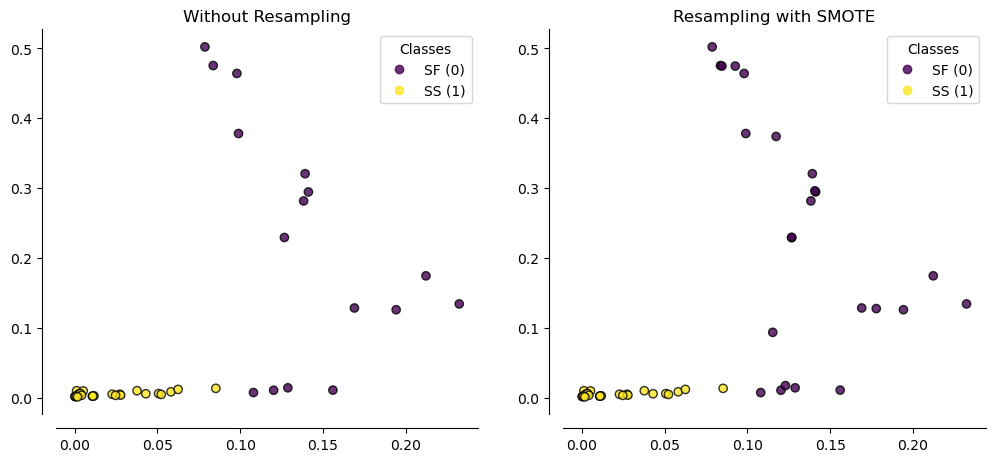

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_resampling(X, y, sampler, ax, title=None, resample=True):
    if resample:
        X_res, y_res = sampler.fit_resample(X, y)
    else:
        X_res, y_res = X, y

    # Select only numeric columns for plotting
    numeric_columns = X_res.select_dtypes(include='number').columns
    if len(numeric_columns) < 2:
        raise ValueError("Insufficient numeric columns for scatter plot")

    # Plotting
    scatter = ax.scatter(X_res[numeric_columns[0]], X_res[numeric_columns[1]], c=y_res, alpha=0.8, edgecolor="k", cmap='viridis')

    # Create a legend with custom class names
    class_names = {0: 'SF (0)', 1: 'SS (1)'}
    unique_classes = list(set(y_res))
    legend_labels = [class_names[cls] if cls in class_names else f'Class {cls}' for cls in unique_classes]
    ax.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title="Classes")

    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}" if resample else "Without Resampling"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_resampling(X_train, y_train, SMOTE(random_state=42), ax2)
plot_resampling(X_train, y_train, SMOTE(random_state=42), ax1, resample=False)
plt.show()


In [237]:
# Print the number of samples per class, before and after SMOTE
print("Number of samples per class before SMOTE:\n{}".format(y_train.value_counts()))
print("Number of samples per class after SMOTE:\n{}".format(y_train_smote.value_counts()))

Number of samples per class before SMOTE:
Scheme
1    24
0    16
Name: count, dtype: int64
Number of samples per class after SMOTE:
Scheme
1    24
0    24
Name: count, dtype: int64


In [238]:
from sklearn.model_selection import cross_val_score
# Train the classifier, using 10-fold cross-validation

# Initialize Naive Bayes classifier
nb_classifier = GaussianNB()

# Perform ten-fold cross-validation
scores = cross_val_score(nb_classifier, X_train_smote, y_train_smote, cv=10)
print("Cross Validation Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

# Train the classifier on the entire training set
nb_classifier.fit(X_train_smote, y_train_smote)

Cross Validation Score: 1.00 (+/- 0.00)


GaussianNB()

In [239]:
# Predict on test data
y_pred = nb_classifier.predict(X_test)

In [240]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Evaluate the model
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

# You can now print out the AUC for ROC and precision-recall curves
print(f"ROC AUC: {roc_auc}")
print(f"Precision-Recall AUC: {pr_auc}")
print("-------------------------")

print("Accuracy:", accuracy_score(y_actual, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# add mcc calculation, prec, recall, f1 score, error rate 
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print("-------------------------")
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)
print("True Positives:", tp)

mcc = ((tp * tn) - (fp * fn)) / (((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5)
f1 = (2 * tp) / ((2 * tp) + fp + fn)
error_rate = (fp + fn) / (tp + tn + fp + fn)
print("-------------------------")
print("MCC:", mcc)
print("F1 Score:", f1)
print("Error Rate:", error_rate)

ROC AUC: 0.8314950980392157
Precision-Recall AUC: 0.9288235294117647
-------------------------
Accuracy: 0.8533333333333334
Confusion Matrix:
 [[37 11]
 [11 91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77        48
           1       0.89      0.89      0.89       102

    accuracy                           0.85       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.85      0.85      0.85       150

-------------------------
True Negatives: 37
False Positives: 11
False Negatives: 11
True Positives: 91
-------------------------
MCC: 0.6629901960784313
F1 Score: 0.8921568627450981
Error Rate: 0.14666666666666667
